In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
from torchwi import Tomo2d
from torchwi.io import rsf
from torchwi.parameter import VelocityParameter

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='6'

In [4]:
fshot="../data_marm/shot.rsf"
fvel="../data_marm/vinit.rsf"

ny,nx,h,vinit = rsf.fromfile(fvel,"n1 n2 d1 data")
nshot,sxy = rsf.fromfile(fshot,"n2 data")

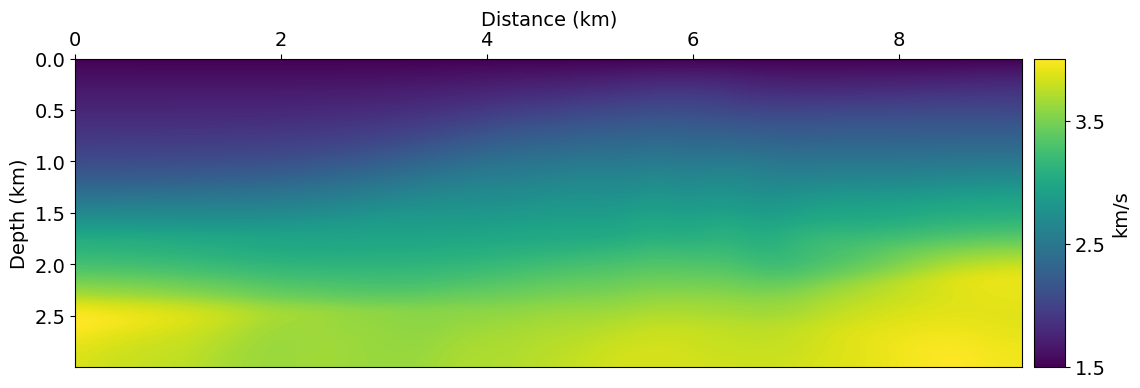

In [5]:
from torchwi.utils.plot import plot_vel
plot_vel(vinit,h)

In [6]:
DEVICE='cuda'
vmin=1.5
vmax=5.5

vp = VelocityParameter(torch.from_numpy(vinit).to(DEVICE),vmin,vmax)

In [7]:
sxy=torch.from_numpy(sxy).to(DEVICE)

sxs = sxy[:,0]
sy = sxy[0,1]
ry = sy

In [8]:
ftrue="../forward/ttime.bin"
truedata_np = np.fromfile(ftrue,dtype=np.float32)
truedata_np.shape = (nshot,nx)
truedata = torch.from_numpy(truedata_np).to(DEVICE)

In [9]:
tomo = Tomo2d(nx,ny,h,device=DEVICE)

alpha = 2*np.pi/(20.*h)*vinit.mean()
freq = 0.05
omega = 2*np.pi*freq - alpha * 1.0j

In [10]:
tomo.factorize(omega, vp())
ttime = tomo.forward(vp(), sxs, sy, ry)
tfrd = ttime.detach().cpu().numpy()

Text(0, 0.5, 'Time (s)')

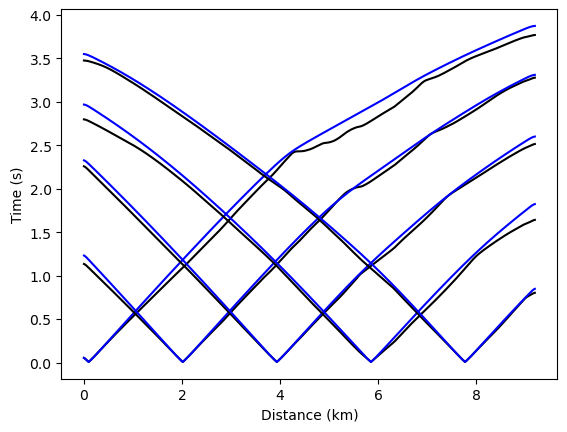

In [11]:
ax = np.arange(nx)*h
for ishot in range(0,nshot,20):
    plt.plot(ax,truedata_np[ishot,:],'k-')
    plt.plot(ax,tfrd[ishot,:],'b-')
plt.xlabel('Distance (km)')
plt.ylabel('Time (s)')

In [12]:
LR=0.001
optimizer= torch.optim.Adam(vp.parameters(), lr=LR)

In [13]:
from torchwi.io import MainLogger
logger=MainLogger()

In [14]:
num_epochs = 300
error = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    tomo.factorize(omega, vp())
    ttime = tomo.forward(vp(), sxs, sy,ry)
    
    loss = 0.5*torch.sum((ttime-truedata)**2)
    loss.backward()
    
    tomo.finalize()
    optimizer.step()
    
    total_loss = loss.item()
    if epoch == 0:
        loss0 = total_loss
    logger.progress_bar(epoch,num_epochs,"norm loss=%9.3e"%(total_loss/loss0))
    error.append(total_loss)

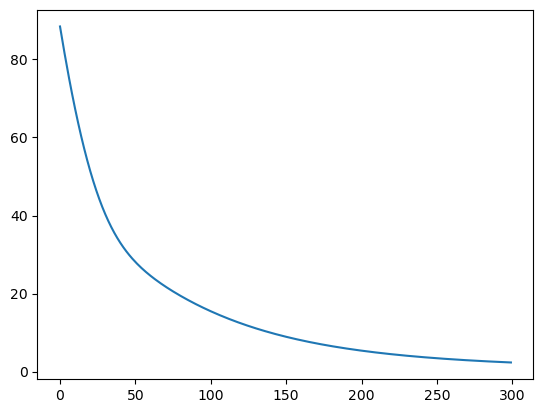

In [15]:
plt.plot(error)

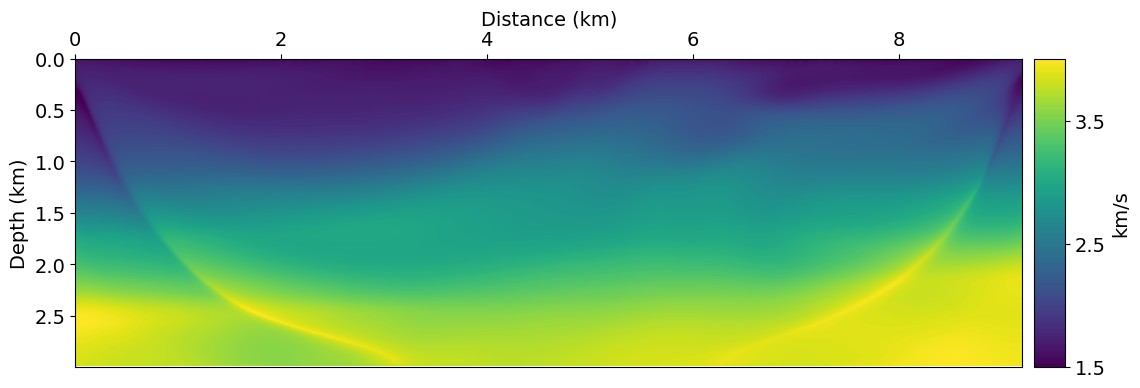

In [16]:
plot_vel(vp().to('cpu').detach().numpy(),h)

Text(0, 0.5, 'Time (s)')

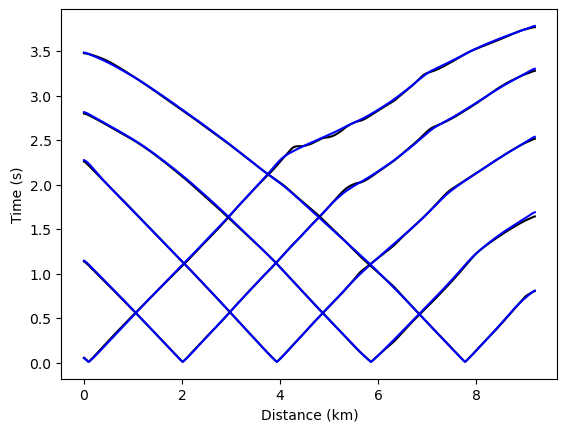

In [17]:
tfrd = ttime.detach().cpu().numpy()

for ishot in range(0,nshot,20):
    plt.plot(ax,truedata_np[ishot,:],'k-')
    plt.plot(ax,tfrd[ishot,:],'b-')
plt.xlabel('Distance (km)')
plt.ylabel('Time (s)')